In [1]:
import torchaudio
import torchaudio.functional as F_audio

In [2]:
def highpass_filter(waveform, sample_rate, cutoff_freq=300):
    return F_audio.highpass_biquad(waveform, sample_rate, cutoff_freq=cutoff_freq)

def amplify_waveform(waveform, gain_db=5):
    vol_transform = torchaudio.transforms.Vol(gain=gain_db)
    return vol_transform(waveform)

def preprocess_waveform(waveform, sample_rate):
    waveform = highpass_filter(waveform, sample_rate, cutoff_freq=300)
    waveform = amplify_waveform(waveform, gain_db=5)
    return waveform

In [3]:
waveform, sample_rate = torchaudio.load("train_audio/21116/iNat65520.ogg")
from IPython.display import Audio

display(Audio(waveform, rate=sample_rate))
waveform_2 = preprocess_waveform(waveform, sample_rate)


In [4]:
display(Audio(waveform_2, rate=sample_rate))

In [ ]:
import librosa
import numpy as np
import noisereduce as nr
def high_frequency_emphasis(y, sr, gain_db=6.0):
    """Apply a simple high-frequency boost."""
    S = librosa.stft(y)
    freqs = librosa.fft_frequencies(sr=sr)
    
    boost = np.ones_like(freqs)
    boost[freqs > 3000] *= 10**(gain_db/20)

    S_boosted = S * boost[:, np.newaxis]
    y_boosted = librosa.istft(S_boosted)
    return y_boosted
filepath="segment_audio/rubsee1/iNat117210_segment_1.wav"
y, sr = librosa.load(filepath, sr=None)

y = nr.reduce_noise(y=y, sr=sr)

# Dynamic range compression
y = librosa.effects.percussive(y) + librosa.effects.harmonic(y)

# (Optional) EQ boost high frequencies
#y = high_frequency_emphasis(y, sr)

# Normalize volume
y = y / np.max(np.abs(y) + 1e-6)

display(Audio(y, rate=sample_rate))

/opt/conda/envs/dmvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
##Chunk into 5 Second Audio files.
import os
import torchaudio
import librosa
import torch

def split_audio(input_path, output_dir, window_size=5, sample_rate=32000):
    audio, sr = torchaudio.load(input_path, normalize=True)
    assert sr == sample_rate, f"Sample rate should be {sample_rate}, but got {sr}"
    
    window_size_samples = window_size * sample_rate 
    if audio.size(1) < window_size_samples:
        padding_length = window_size_samples - audio.size(1)
        audio = torch.nn.functional.pad(audio, (0, padding_length))

    output_files = []
    total_length = audio.size(1)
    num_segments = total_length // window_size_samples

    for i in range(num_segments):
        start_idx = i * window_size_samples
        end_idx = start_idx + window_size_samples
        segment = audio[:, start_idx:end_idx]

        segment_filename = f"{os.path.splitext(os.path.basename(input_path))[0]}_segment_{i+1}.wav"
        segment_path = os.path.join(output_dir, segment_filename)

        torchaudio.save(segment_path, segment, sample_rate)
        output_files.append(segment_path)

    return output_files

In [ ]:
import os

directory = "train_audio"
outpath_name = "segment_audio"
os.makedirs(outpath_name, exist_ok=True)
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    file_out = os.path.join(outpath_name, subdir)
    os.makedirs(file_out, exist_ok=True)
    for file in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, file)
        split_audio(file_path,file_out)

In [3]:
import os

directory = "train_soundscapes"
outpath_name = "segment_audio_ss"
os.makedirs(outpath_name, exist_ok=True)
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    file_out = os.path.join(outpath_name)
    split_audio(file_path,file_out)

In [3]:
from multi_label_dataset import MultiLabelAudioDataset,load_dataloaders
annotation_file = "multi_label_predictions.json"
train_loader, test_loader, num_classes = load_dataloaders(annotation_file)
for audio in train_loader:
    print(audio["audio"])
    
    break

tensor([[ 5.1307e-03,  3.1722e-03, -3.0680e-03,  ..., -8.8266e-04,
         -4.8156e-03, -3.4802e-03],
        [ 1.0542e-03,  7.4288e-04,  1.3453e-04,  ...,  2.9691e-04,
         -1.7984e-03,  5.3731e-05],
        [ 6.7998e-02,  1.2019e-01,  8.8958e-02,  ...,  3.9189e-03,
         -4.5033e-02, -6.9699e-02]])


In [1]:
import json
with open(annotation_file) as f:
    annotations = json.load(f)
temp = []
for annotation in annotations:
    temp.append((max(list(annotation.values())[0])))
print(num_classes, max(temp))

NameError: name 'annotation_file' is not defined

In [14]:
import random
from collections import defaultdict
from torch.utils.data import Sampler, DataLoader

# Example Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Custom Sampler
class DistinctClassBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        assert batch_size % 2 == 0, "Batch size must be even (2 samples per class)"
        self.labels = labels
        self.batch_size = batch_size
        self.samples_per_class = 2
        self.classes_per_batch = batch_size // self.samples_per_class

        # Map class -> list of indices
        self.label_to_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            self.label_to_indices[label].append(idx)
        
        self.classes = list(self.label_to_indices.keys())

    def __iter__(self):
        all_samples = []

        # Shuffle classes at the start of each epoch
        random.shuffle(self.classes)

        # Iterate through all the classes and samples
        for cls in self.classes:
            indices = self.label_to_indices[cls]
            random.shuffle(indices)  # Shuffle indices within each class

            # Select 2 samples per class and add them to the batch
            for i in range(0, len(indices), self.samples_per_class):
                batch = indices[i:i+self.samples_per_class]  # Correctly slice the indices
                all_samples.append(batch)

        random.shuffle(all_samples)  # Shuffle the batches
        for batch in all_samples:
            print(batch)
            yield batch

    def __len__(self):
        return len(self.labels) // self.batch_size


# Sample Data
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = [0, 1, 2, 3, 4, 0, 1, 2, 3, 4]  # 5 classes, 2 samples per class

# Create Dataset
dataset = MyDataset(data)

# Create DataLoader with custom sampler
batch_size = 4
sampler = DistinctClassBatchSampler(labels, batch_size)
dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# Iterate through batches
for batch in dataloader:
    print(batch)


[8, 3]
[2, 7]
[5, 0]
[6, 1]


TypeError: list indices must be integers or slices, not list

In [42]:
os.path.basename(os.path.dirname("yelori1/iNat45330_segment_1.wav"))

'yelori1'

In [2]:
from dataset import ContrastiveDataset
from torch.utils.data import DataLoader
import os
directory="segment_audio"
dataset_files = [os.path.join(directory, subdir, file) for subdir in os.listdir(directory) for file in os.listdir(os.path.join(directory, subdir))]
dataset = ContrastiveDataset(dataset_files)

encodingDataLoader = DataLoader(dataset)

In [3]:
os.path.basename(os.path.dirname(dataset_files[0]))

'rubsee1'

In [4]:
for (anchor, positive, label_positive), (anchor, negative, label_negative) in encodingDataLoader:
    print(anchor.shape, positive.shape, negative.shape)
    break

/opt/conda/envs/dmvenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=313
  warnings.warn(


torch.Size([1, 1025, 313]) torch.Size([1, 1025, 1025, 1]) torch.Size([1, 1025, 313])


In [1]:
from dataset import ContrastiveDataset
from torch.utils.data import DataLoader
import os
directory="segment_audio"
dataset_files = [os.path.join(directory, subdir, file) for subdir in os.listdir(directory) for file in os.listdir(os.path.join(directory, subdir))]
dataset = ContrastiveDataset(dataset_files)

encodingDataLoader = DataLoader(dataset)
for (anchor, positive, label_positive), (anchor, negative, label_negative) in encodingDataLoader:
    print(anchor.shape, positive.shape, negative.shape)
    break

/opt/conda/envs/dmvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/dmvenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=626
  warnings.warn(


torch.Size([1, 513, 626]) torch.Size([1, 513, 513, 3]) torch.Size([1, 513, 626])


/opt/conda/envs/dmvenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=626
  warnings.warn(
/opt/conda/envs/dmvenv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=626
  warnings.warn(


torch.Size([1, 513, 626]) torch.Size([1, 513, 513, 3]) torch.Size([1, 513, 626])


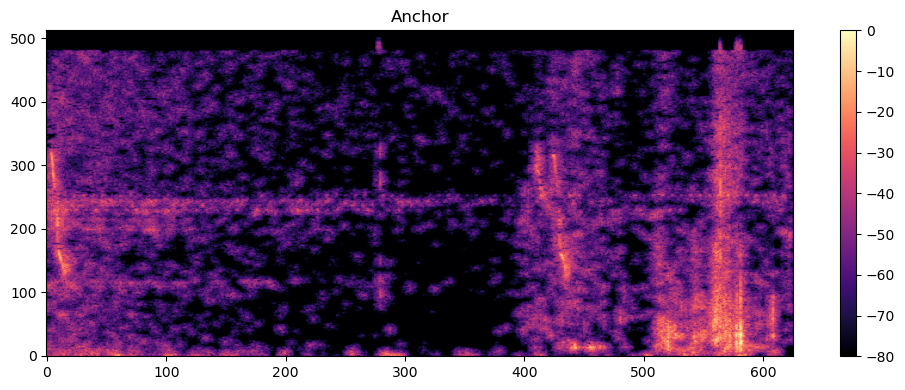

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-80.00001..-7.6293945e-06].


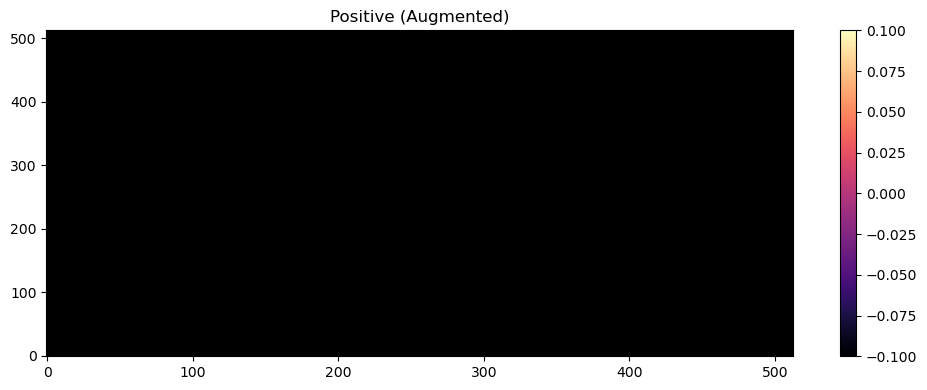

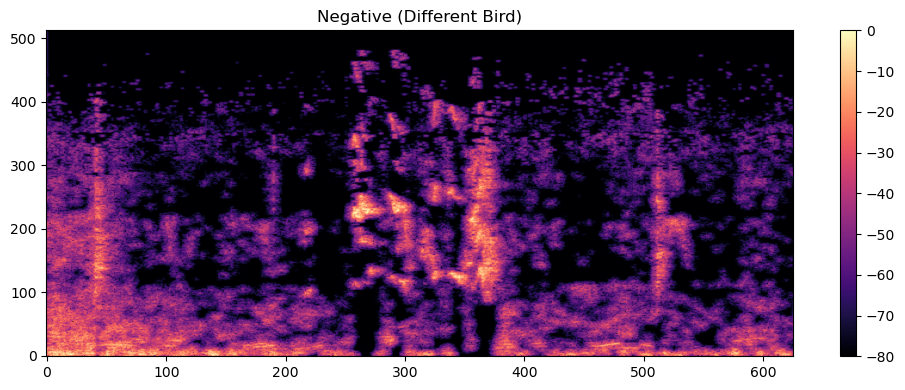

In [2]:
import matplotlib.pyplot as plt
import torch

def plot_spectrogram(spectrogram, title):
    spectrogram = spectrogram.squeeze().cpu().numpy() 
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='magma')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Load one batch
for (anchor, positive, label_positive), (anchor, negative, label_negative) in encodingDataLoader:
    print(anchor.shape, positive.shape, negative.shape)

    plot_spectrogram(anchor[0], "Anchor")
    plot_spectrogram(positive[0], "Positive (Augmented)")
    plot_spectrogram(negative[0], "Negative (Different Bird)")
    
    break